<div class="output_png output_subarea output_execute_result">
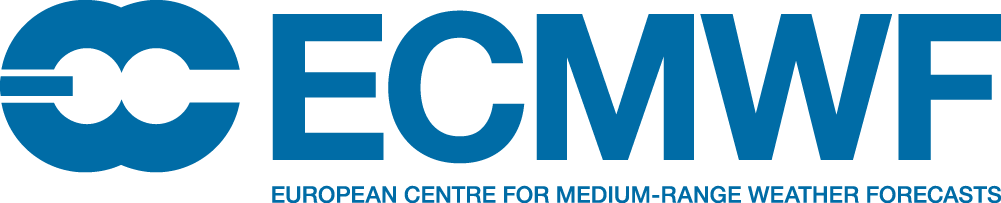
</div>

# Sunshine duration, last 24 hours

This notebook will provide you guidance how to explore ECMWF data to produce the map from the ECMWF open charts web product.    
The original product can be found on this link: https://charts.ecmwf.int/products/medium-sund_interval 


<div class="output_png output_subarea output_execute_result">
<center>
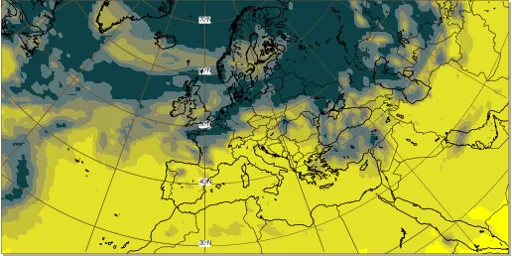
</div>

Some ECMWF real-time products are governed by the [ECMWF Standard Licence Agreement](https://www.ecmwf.int/sites/default/files/ECMWF_Standard_Licence.pdf) and are not free or open. Access to these products depends on your use case. To find out which licence applies to you, please visit: [Use cases and licence conditions page](https://www.ecmwf.int/en/forecasts/accessing-forecasts/licences-available).  

To find out how to obtain the access to the ECMWF forecast data please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input parameter:

* [	Sunshine duration](https://codes.ecmwf.int/grib/param-db/189)

In this example, we will use: 
- [**ecmwf-api-client**](https://pypi.org/project/ecmwf-api-client/) to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next two cells.
</div>

In [1]:
#!pip install ecmwf-api-client

In [1]:
#!conda install metview metview-python

In [1]:
import metview as mv
from ecmwfapi import *
import requests

In [2]:
filename = 'medium-sund_interval.grib'

If you already have the access to the ECMWF archived forecast data, you can use the next cell to download data from the [MARS archive](https://confluence.ecmwf.int/display/UDOC/MARS+user+documentation):

In [ ]:
server = ECMWFService("mars")
server.execute(
    {
    "class": "od",
    "date": "-1",
    "expver": "1",
    "levtype": "sfc",
    "param": "189",
    "step": "24/48/72",
    "stream": "oper",
    "time": "00",
    "type": "fc",
    "grid": "0.25/0.25"
    },
    filename)

Alternatively we have prepared small sample dataset to explore

In [3]:
url = f"https://sites.ecmwf.int/repository/opencharts-sample-data/{filename}"
r = requests.get(url)
with open(filename, 'wb') as file:
    file.write(r.content)

## Reading and processing the data
Now we can use **Metview's read() function** to read the file.

In [4]:
data = mv.read(filename)

The **describe()** function will give us the overview of the dataset.  

In [5]:
data.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
sund,surface,0,20250727,0,"24,48,...",189,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [6]:
data.describe('sund')

shortName,sund
name,Sunshine duration
paramId,189
units,s
typeOfLevel,surface
level,0
date,20250727
time,0
step,"24,48,72"
class,od
stream,oper


We can use **ls()** function to list all the fields in the file we downloaded.

In [7]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,sund,surface,0,20250727,0,24,fc,regular_ll
1,ecmf,sund,surface,0,20250727,0,48,fc,regular_ll
2,ecmf,sund,surface,0,20250727,0,72,fc,regular_ll


Sunshine duration is accumulated parameter, which means the data is accumulated from the start of the forecast period up to the forecast step.  
In order to calculate the sunshine duration for the second day of the forecast (24hr period before the step 48), we need to substract step 24 from step 48.

In [8]:
sund_48 = data.select(step=48)
sund_24 = data.select(step=24)
sund = sund_48 - sund_24

Sunshine duration units are seconds, and in the graphical product it is displayed in hours.  
We need to, therefore convert to hours by dividing with the number of seconds in an hour.

In [9]:
sund /= 3600

## Plotting the data
And finally, we can plot the data on the map. 

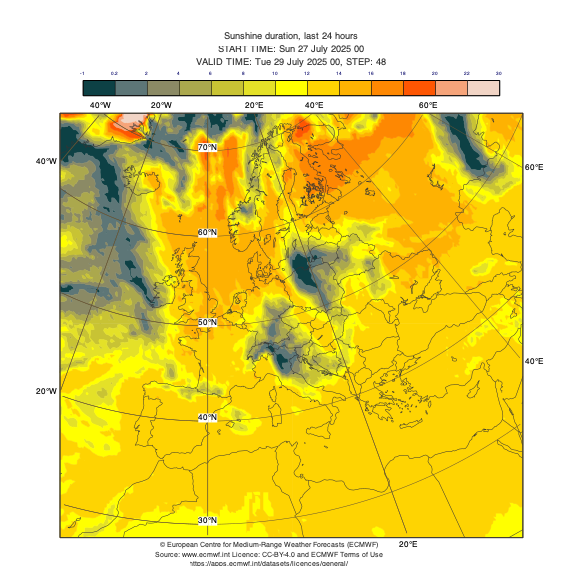

In [10]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
sund_shade = mv.mcont(legend= "on",
    contour = "off",
    contour_hilo = "off",
    contour_label = "off",
    contour_level_list = [-1, 0.2, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 30],
    contour_level_selection_type = "level_list",
    contour_shade = "on",
    contour_shade_colour_list = ["RGB(0.05107,0.2559,0.2705)", "RGB(0.3635,0.4626,0.4679)", "RGB(0.5444,0.5395,0.3968)", 
                                 "RGB(0.6712,0.6589,0.3013)", "RGB(0.7848,0.7654,0.2035)", "RGB(0.8939,0.8817,0.157)", 
                                 "yellow", "RGB(0.9941,0.8301,0.009781)", "RGB(0.9941,0.6988,0.009781)", 
                                 "RGB(0.9941,0.5348,0.009781)", "RGB(0.9941,0.3379,0.009781)", "RGB(0.964,0.6408,0.4792)", 
                                 "RGB(0.9446,0.8302,0.773)"],
    contour_shade_colour_method = "list",
    contour_shade_method = "area_fill")

title = mv.mtext(
    text_lines = ["Sunshine duration, last 24 hours",
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H'/>, STEP: <grib_info key='step'/>"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, sund, sund_shade, title, ecmwf_text)

To generate the png file you can run the following cell.

In [11]:
png = mv.png_output(
    output_name = "medium-sund_interval",    # specify relative or full path
    output_title = "medium-sund_interval",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, data, sund_shade, title, ecmwf_text)

Note that plot produced using this dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
The data used here is on 0.25x0.25 resolution, while high resolution data is 0.1x0.1 grid.